In [1]:
!pip install -U -q tensorflow tensorflow_datasets

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [6]:


DATASET_PATH = 'data/speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands_v0.02.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.',
      cache_subdir='data'
  )


2428923189/2428923189 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


In [9]:
print(os.getcwd())  # Prints the current working directory
print(os.listdir('.'))  # Lists the files and directories in the current directory



/content
['.config', 'data', 'sample_data']


In [10]:
print(os.listdir('/content/data'))

['speech_commands_v0.02.tar.gz', 'right', 'eight', 'two', 'on', 'dog', 'bed', 'no', 'nine', 'cat', 'one', 'up', 'five', 'backward', 'left', 'learn', 'marvin', 'README.md', 'go', 'follow', 'tree', 'off', 'validation_list.txt', 'testing_list.txt', 'stop', 'zero', 'six', 'visual', '.DS_Store', 'down', 'forward', 'LICENSE', 'happy', 'house', 'three', '_background_noise_', 'sheila', 'wow', 'seven', 'four', 'yes', 'bird']


In [12]:

data_dir = '/content/data'


if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The directory {data_dir} does not exist.")
else:
    print(f"Directory exists: {data_dir}")


Directory exists: /content/data


In [13]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['speech_commands_v0.02.tar.gz' 'right' 'eight' 'two' 'on' 'dog' 'bed'
 'no' 'nine' 'cat' 'one' 'up' 'five' 'backward' 'left' 'learn' 'marvin'
 'go' 'follow' 'tree' 'off' 'validation_list.txt' 'testing_list.txt'
 'stop' 'zero' 'six' 'visual' 'down' 'forward' 'LICENSE' 'happy' 'house'
 'three' '_background_noise_' 'sheila' 'wow' 'seven' 'four' 'yes' 'bird']


In [14]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.

label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [15]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [16]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [17]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [18]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [19]:
label_names[[1,1,3,0]]

array(['backward', 'backward', 'bird', '_background_noise_'], dtype='<U18')

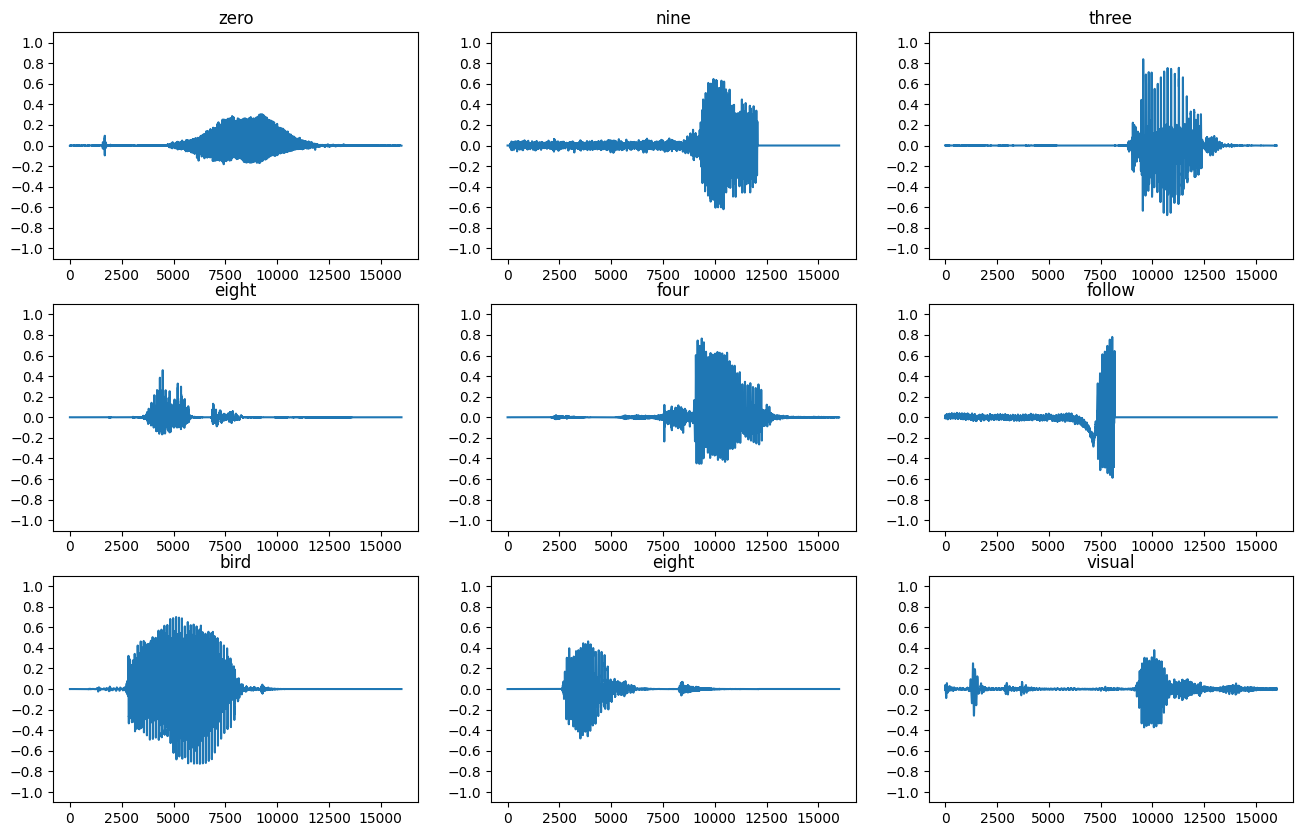

In [20]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [21]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [22]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: zero
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [23]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

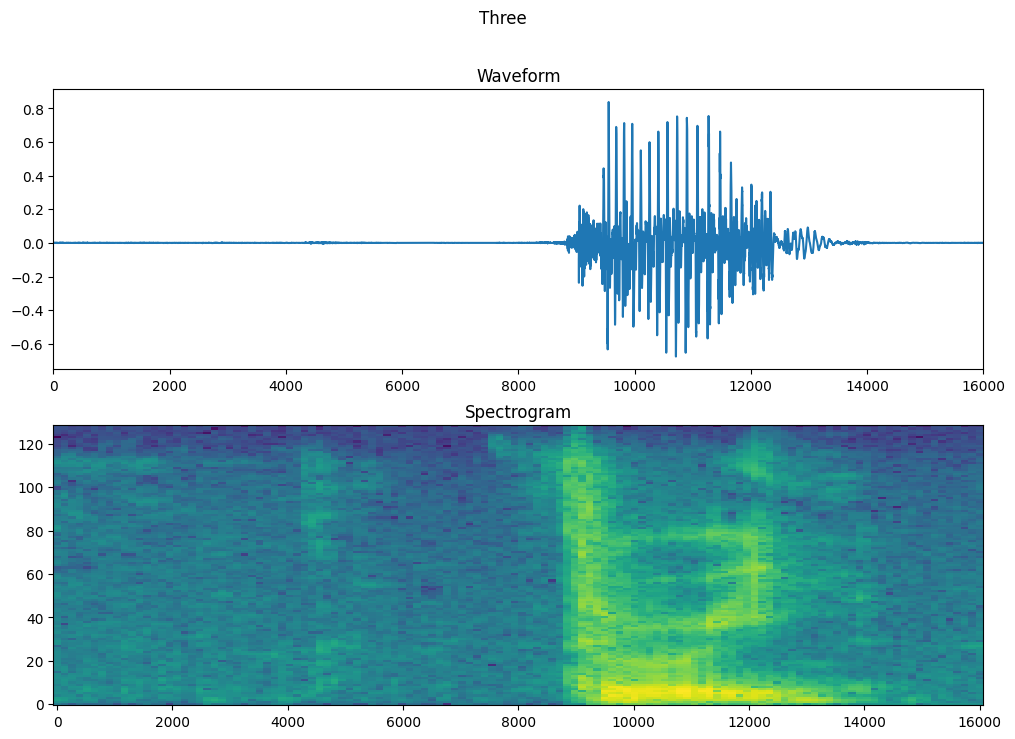

In [24]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [25]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [27]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

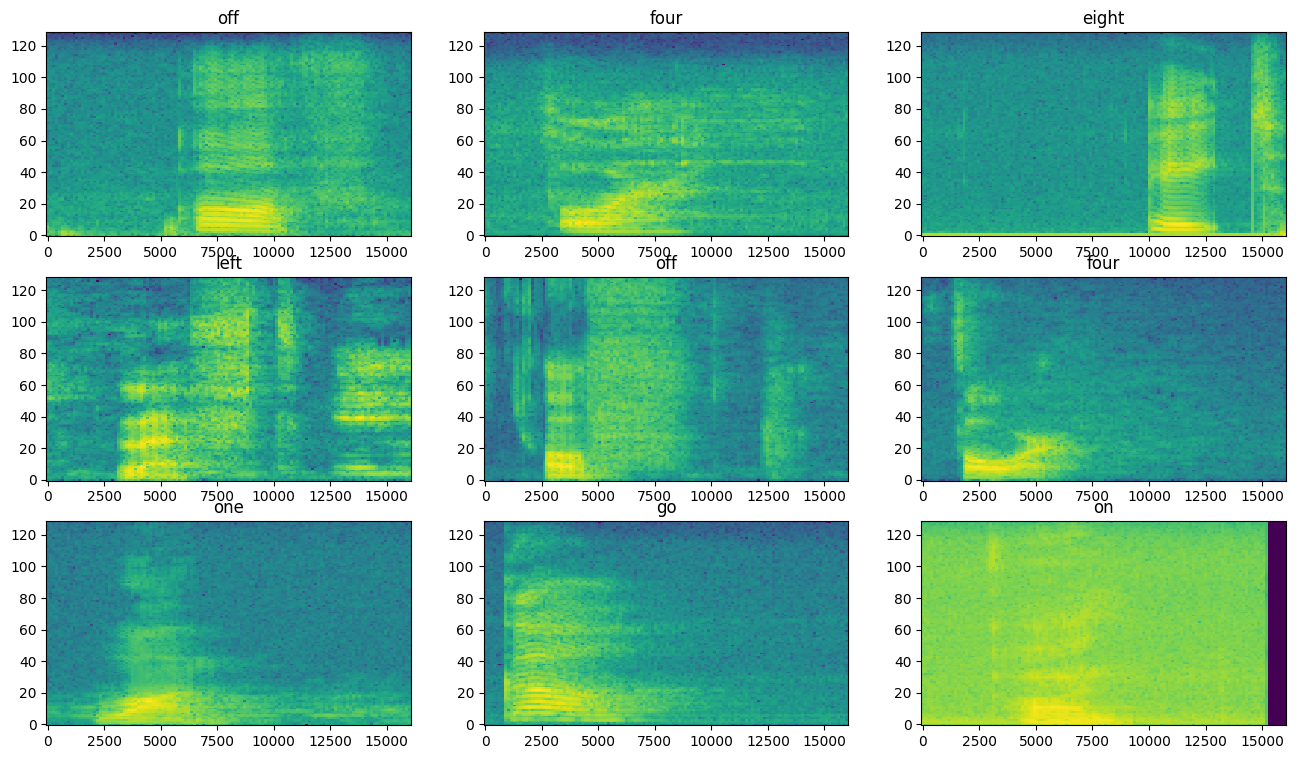

In [28]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [29]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [30]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,629,223 (6.21 MB)

 Trainable params: 1,629,220 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [32]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 403s 301ms/step - accuracy: 0.2872 - loss: 2.5859 - val_accuracy: 0.6958 - val_loss: 1.0869
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 390s 262ms/step - accuracy: 0.6118 - loss: 1.3235 - val_accuracy: 0.7521 - val_loss: 0.8775
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 353s 267ms/step - accuracy: 0.6798 - loss: 1.0751 - val_accuracy: 0.7868 - val_loss: 0.7389
Epoch 4/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 345s 260ms/step - accuracy: 0.7157 - loss: 0.9434 - val_accuracy: 0.8064 - val_loss: 0.6755
Epoch 5/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 373s 254ms/step - accuracy: 0.7425 - loss: 0.8503 - val_accuracy: 0.8147 - val_loss: 0.6409
Epoch 6/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 378s 251ms/step - accuracy: 0.7577 - loss: 0.7926 - val_accuracy: 0.8209 - val_loss: 0.6112
Epoch 7/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 373s 245ms/step - accuracy: 0.7738 - loss: 0.7392 - val_accuracy: 0.8285 - val_loss: 0.5794
Epoch 8/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 334s 252ms/step - ac

Text(0, 0.5, 'Accuracy [%]')

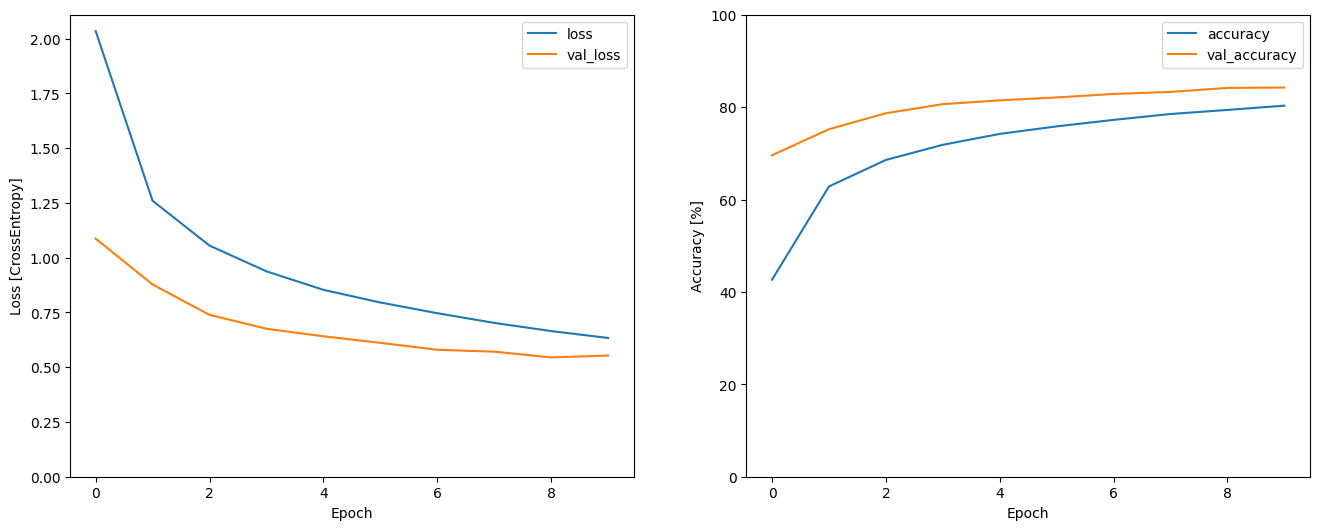

In [33]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [34]:
model.evaluate(test_spectrogram_ds, return_dict=True)

166/166 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.8423 - loss: 0.5475


{'accuracy': 0.844065248966217, 'loss': 0.5401184558868408}

In [35]:
y_pred = model.predict(test_spectrogram_ds)

166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step


In [36]:
y_pred = tf.argmax(y_pred, axis=1)

In [37]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

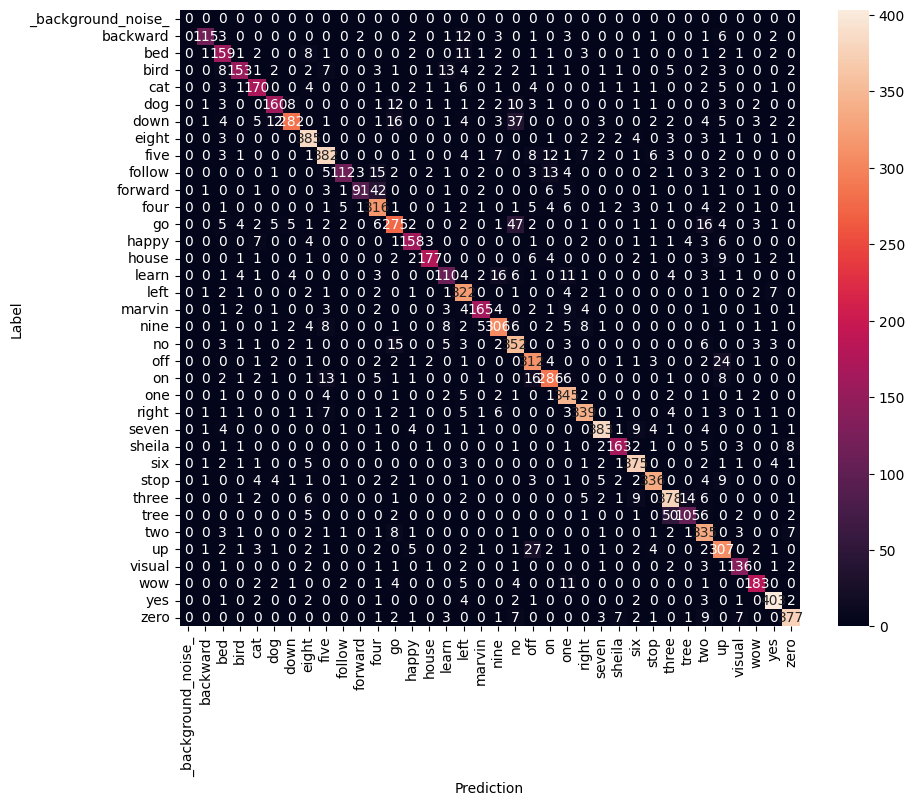

In [38]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

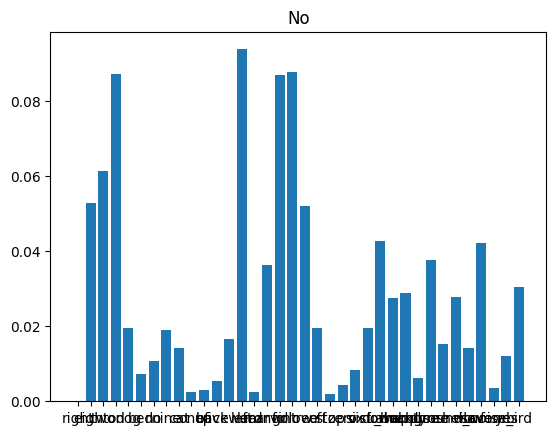

In [47]:
x = '/content/no.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = [ 'right', 'eight', 'two', 'on', 'dog', 'bed', 'no',
            'nine', 'cat', 'one', 'up', 'five', 'backward', 'left', 'learn', 'marvin',
            'go', 'follow', 'tree', 'off', 'stop', 'zero', 'six', 'visual',  'down', 'forward',
            'happy', 'house', 'three', '_background_noise_', 'sheila', 'wow', 'seven', 'four', 'yes', 'bird']


plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))